In [ ]:
'''
This cell loads the model from the config file and initializes the viewer
'''
# %matplotlib widget
import torch
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import numpy as np
from nerfstudio.viewer.viewer import Viewer
from nerfstudio.configs.base_config import ViewerConfig
import cv2
from torchvision.transforms import ToTensor
from PIL import Image
from typing import List,Optional,Literal
from nerfstudio.utils import writer
import time
from threading import Lock
# config = Path("outputs/garfield_plushie/dig/2024-04-08_095834/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim, 1260

config = Path("outputs/buddha_balls/dig/2024-04-22_100035/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim, 1260

# config = Path("outputs/table_scan/dig/2024-03-21_123358/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim

# config = Path("outputs/nerfgun2/dig/2024-04-05_110412/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim, res 1260

# config = Path("outputs/boops_mug/dig/2024-03-20_110937/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim

# config = Path("outputs/tissue_scan/dig/2024-03-21_141012/config.yml")#with garfield, patch size 14, with denoising, 48->64 dim
train_config,pipeline,_,_ = eval_setup(config)
dino_loader = pipeline.datamanager.dino_dataloader
train_config.logging.local_writer.enable = False
# We need to set up the writer to track number of rays, otherwise the viewer will not calculate the resolution correctly
writer.setup_local_writer(train_config.logging, max_iter=train_config.max_num_iterations)
v = Viewer(ViewerConfig(default_composite_depth=False,num_rays_per_chunk=-1),config.parent,pipeline.datamanager.get_datapath(),pipeline,train_lock=Lock())

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from typing import Union
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
model.to('cuda')
def get_depth(img: Union[torch.tensor,np.ndarray]):
    assert img.shape[2] == 3
    if isinstance(img,torch.Tensor):
        img = img.cpu().numpy()
    image = Image.fromarray(img)

    # prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")
    inputs['pixel_values'] = inputs['pixel_values'].cuda()

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    return prediction.squeeze()


In [ ]:
"""
This cell defines a simple pose optimizer for learning a rigid transform offset given a gaussian model, star pose, and starting view
"""
from lerf.dig import DiGModel
from lerf.data.utils.dino_dataloader import DinoDataloader
from nerfstudio.cameras.cameras import Cameras
from copy import deepcopy
from torchvision.transforms.functional import resize
import torchvision
from gsplat._torch_impl import quat_to_rotmat
from contextlib import nullcontext
# from nerfstudio.model_components.losses import depth_ranking_loss

def get_vid_frame(cap,timestamp):
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate the frame number based on the timestamp and fps
    frame_number = min(int(timestamp * fps),int(cap.get(cv2.CAP_PROP_FRAME_COUNT)-1))
    
    # Set the video position to the calculated frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    success, frame = cap.read()
    # convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame
        
def quatmul(q0:torch.Tensor,q1:torch.Tensor):
    w0, x0, y0, z0 = torch.unbind(q0, dim=-1)
    w1, x1, y1, z1 = torch.unbind(q1, dim=-1)
    return torch.stack(
            [
                -x0 * x1 - y0 * y1 - z0 * z1 + w0 * w1,
                x0 * w1 + y0 * z1 - z0 * y1 + w0 * x1,
                -x0 * z1 + y0 * w1 + z0 * x1 + w0 * y1,
                x0 * y1 - y0 * x1 + z0 * w1 + w0 * z1,
            ],
            dim = -1
        )

def cauchy_loss(x:torch.Tensor, y:torch.Tensor, scale:float = 1.0):
    """
    Cauchy loss between x and y
    """
    return torch.log(1 + ((x - y) / scale) ** 2).mean()

def depth_ranking_loss(rendered_depth, gt_depth):
    """
    Depth ranking loss as described in the SparseNeRF paper
    Assumes that the layout of the batch comes from a PairPixelSampler, so that adjacent samples in the gt_depth
    and rendered_depth are from pixels with a radius of each other
    """
    m = 1e-4
    if rendered_depth.shape[0] % 2 != 0:
        # chop off one index
        rendered_depth = rendered_depth[:-1, :]
        gt_depth = gt_depth[:-1, :]
    dpt_diff = gt_depth[::2, :] - gt_depth[1::2, :]
    out_diff = rendered_depth[::2, :] - rendered_depth[1::2, :] + m
    differing_signs = torch.sign(dpt_diff) != torch.sign(out_diff)
    loss = (out_diff[differing_signs] * torch.sign(out_diff[differing_signs]))
    med = loss.median()
    return loss[loss < med].mean()

@torch.no_grad
def get_scale_and_shift(x:torch.Tensor):
    shift = x.median()
    devs = (x - shift).abs()#median deviation is the scale
    return devs.median(),shift 

class ATAPLoss:
    touch_radius: float = .005
    N: int = 200
    loss_mult: float = 0.2
    def __init__(self, dig_model: DiGModel, group_masks: List[torch.Tensor]):
        """
        Initializes the data structure to compute the loss between groups touching
        """
        self.dig_model = dig_model
        self.group_masks = group_masks
        self.nn_info = []
        for grp in self.group_masks:
            dists, ids, match_ids, group_ids = self._radius_nn(grp, self.touch_radius)
            with torch.no_grad():
                self.nn_info.append((dists, ids, match_ids, group_ids))
        

    def __call__(self, connectivity_weights: torch.Tensor):
        """
        Computes the loss between groups touching
        connectivity_weights: a tensor of shape (num_groups,num_groups) representing the weights between each group

        returns: a differentiable loss
        """
        assert connectivity_weights.shape == (len(self.group_masks),len(self.group_masks)), "connectivity weights must be a square matrix of size num_groups"
        atap_loss = torch.zeros(1,dtype=torch.float32,device='cuda')
        for i,grp in enumerate(self.group_masks):
            orig_dists, ids, match_ids, group_ids = self.nn_info[i]
            match_means = self.dig_model.means[match_ids]
            grp_means = self.dig_model.means[ids]
            dists = (grp_means - match_means).norm(dim=-1)
            # weight the dists by the connectivity weights
            weights_for_this_group = connectivity_weights[i]
            connection_weights = weights_for_this_group[group_ids]
            dists_loss_prereduce = (dists - orig_dists).abs() * connection_weights * self.loss_mult
            dists_loss = dists_loss_prereduce.mean()
            if not dists_loss.isnan():
                atap_loss = atap_loss + dists_loss
        return atap_loss
        

    def _radius_nn(self, group_mask: torch.Tensor, r: float):
        """
        returns the nearest neighbors to gaussians in a group within a certain radius (and outside that group)
        returns -1 indices for neighbors outside the radius or within the same group
        """
        global_group_ids = torch.zeros(self.dig_model.num_points,dtype=torch.long,device='cuda')
        for i,grp in enumerate(self.group_masks):
            global_group_ids[grp] = i
        from cuml.neighbors import NearestNeighbors
        model = NearestNeighbors(n_neighbors=self.N)
        means = self.dig_model.means.detach().cpu().numpy()
        model.fit(means)
        dists, match_ids = model.kneighbors(means)
        dists, match_ids = torch.tensor(dists,dtype=torch.float32,device='cuda'),torch.tensor(match_ids,dtype=torch.long,device='cuda')
        dists, match_ids = dists[group_mask], match_ids[group_mask]
        # filter matches outside the radius
        match_ids[dists>r] = -1
        # filter out ones within same group mask
        match_ids[group_mask[match_ids]] = -1
        ids = torch.arange(self.dig_model.num_points,dtype=torch.long,device='cuda')[group_mask].unsqueeze(-1).repeat(1,self.N)
        #flatten all the ids/dists/match_ids
        ids = ids[match_ids!=-1].flatten()
        dists = dists[match_ids!=-1].flatten()
        match_ids = match_ids[match_ids!=-1].flatten()
        return dists, ids, match_ids, global_group_ids[match_ids]


class RigidGroupOptimizer:
    use_depth: bool = False
    use_atap: bool = True
    def __init__(self, dig_model: DiGModel, dino_loader: DinoDataloader, init_c2o: Cameras, group_masks: List[torch.Tensor], render_lock = nullcontext()):
        """
        This one takes in a list of gaussian ID masks to optimize local poses for
        Each rigid group can be optimized independently, with no skeletal constraints
        """
        self.dig_model = dig_model
        #detach all the params to avoid retain_graph issue
        self.dig_model.gauss_params['means'] = self.dig_model.gauss_params['means'].detach()
        self.dig_model.gauss_params['quats'] = self.dig_model.gauss_params['quats'].detach()
        self.dino_loader = dino_loader
        self.group_masks = group_masks
        self.init_c2o = deepcopy(init_c2o).to('cuda')
        #store a 7-vec of trans, rotation for each group
        self.pose_deltas = torch.zeros(len(group_masks),7,dtype=torch.float32,device='cuda')
        self.pose_deltas[:,3:] = torch.tensor([1,0,0,0],dtype=torch.float32,device='cuda')
        self.pose_deltas = torch.nn.Parameter(self.pose_deltas)
        lr = .012
        self.optimizer = torch.optim.Adamax([self.pose_deltas],lr=lr)
        self.init_means = dig_model.gauss_params['means'].detach().clone()
        self.init_quats = dig_model.gauss_params['quats'].detach().clone()
        self.blur = torchvision.transforms.GaussianBlur(kernel_size=[13,13]).cuda()
        self.keyframes = []
        # lock to prevent blocking the render thread if provided
        self.render_lock = render_lock

        self.atap = ATAPLoss(dig_model,group_masks)
        self.connectivity_weights = torch.ones(len(group_masks),len(group_masks),dtype=torch.float32,device='cuda')

    def step(self, niter = 1, use_depth = True, use_rgb = False):
        self.dig_model.eval()
        for i in range(niter):
            self.optimizer.zero_grad()
            with self.render_lock:
                self.dig_model.eval()
                self.apply_to_model(self.pose_deltas)
                dig_outputs = self.dig_model.get_outputs(self.init_c2o)
            if 'dino' not in dig_outputs:
                self.reset_transforms()
                raise RuntimeError("Lost tracking")
            loss = 0
            dino_feats = self.blur(dig_outputs["dino"].permute(2,0,1)).permute(1,2,0).contiguous()
            pix_loss = (self.frame_pca_feats - dino_feats)
            # THIS IS BAD WE NEED TO FIX THIS (because resizing makes the image very slightly misaligned)
            loss = pix_loss.norm(dim=-1).mean()
            if use_depth and self.use_depth:
                object_mask = dig_outputs['accumulation']>.9
                disparity = 1.0 / dig_outputs['depth']
                N = 20000
                valid_ids = torch.where(object_mask)
                rand_samples = torch.randint(0,valid_ids[0].shape[0],(N,))
                rand_samples = (valid_ids[0][rand_samples],valid_ids[1][rand_samples])
                rend_samples = disparity[rand_samples]
                mono_samples = self.frame_depth[rand_samples]
                rank_loss = depth_ranking_loss(rend_samples,mono_samples)
                '''Things to trry
                ignore rim by eroding mask
                try huber, cauchy, or other robust loss
                maybe ignore upper quantile of loss or something
                '''
                loss = loss + .1*rank_loss
            if use_rgb:
                loss = loss + .05*(dig_outputs['rgb']-self.rgb_frame).abs().mean()
            if self.use_atap:
                atap_loss = self.atap(self.connectivity_weights)
                loss = loss + atap_loss
            loss.backward()
            self.optimizer.step()
        return dig_outputs
    
    def apply_to_model(self, pose_deltas):
        """
        Takes the current pose_deltas and applies them to each of the group masks
        """
        self.reset_transforms()
        quat_deltas = torch.empty((self.dig_model.num_points,4),dtype=torch.float32,device='cuda', requires_grad=True)
        Hs = torch.empty((self.dig_model.num_points,3,4),dtype=torch.float32,device='cuda', requires_grad=True)
        for i,mask in enumerate(self.group_masks):
            ps = pose_deltas[i:i+1,3:]/pose_deltas[i:i+1,3:].norm(dim=1,keepdim=True)
            quat_deltas = torch.where(mask[...,None],ps,quat_deltas)
            H = torch.cat([quat_to_rotmat(pose_deltas[i:i+1,3:]),pose_deltas[i:i+1,:3].T.unsqueeze(0)],dim=2)
            Hs = torch.where(mask[...,None,None],H,Hs)
        with torch.no_grad():
            self.dig_model.gauss_params['quats'] = quatmul(quat_deltas,self.dig_model.gauss_params['quats'])
        self.dig_model.gauss_params['means'] = Hs[:,:3,3] + torch.bmm(Hs[:,:3,:3],self.dig_model.gauss_params['means'][...,None]).squeeze()

    def register_keyframe(self):
        """
        Saves the current pose_deltas as a keyframe
        """
        self.keyframes.append(self.pose_deltas.detach().clone())

    def apply_keyframe(self,i):
        """
        Applies the ith keyframe to the pose_deltas
        """
        with torch.no_grad():
            self.apply_to_model(self.keyframes[i])

    def reset_transforms(self):
        with torch.no_grad():
            self.dig_model.gauss_params['means'] = self.init_means.clone()
            self.dig_model.gauss_params['quats'] = self.init_quats.clone()

    def set_frame(self, rgb_frame: torch.Tensor):
        """
        Sets the rgb_frame to optimize the pose for
        rgb_frame: HxWxC tensor image
        init_c2o: initial camera to object transform (given whatever coordinates the self.dig_model is in)
        """
        with torch.no_grad():
            self.rgb_frame = resize(rgb_frame.permute(2,0,1), (self.init_c2o.height,self.init_c2o.width)).permute(1,2,0).contiguous()
            self.frame_pca_feats = self.dino_loader.get_pca_feats(rgb_frame.permute(2,0,1).unsqueeze(0),keep_cuda=True).squeeze()
            self.frame_pca_feats = resize(self.frame_pca_feats.permute(2,0,1), (self.init_c2o.height,self.init_c2o.width)).permute(1,2,0).contiguous()
            if self.use_depth:
                depth = get_depth((rgb_frame*255).to(torch.uint8))
                self.frame_depth = resize(depth.unsqueeze(0), (self.init_c2o.height,self.init_c2o.width)).squeeze().unsqueeze(-1)

MATCH_RESOLUTION = 500
train_cam_pose,data = pipeline.datamanager.next_train(0)
view_cam_pose = pipeline.viewer_control.get_camera(200,None,0)
train_cam_pose.camera_to_worlds = view_cam_pose.camera_to_worlds
train_cam_pose.rescale_output_resolution(MATCH_RESOLUTION/max(train_cam_pose.width,train_cam_pose.height))
outputs = pipeline.model.get_outputs_for_camera(train_cam_pose)
if pipeline.cluster_labels is not None:
    labels = pipeline.cluster_labels.int()
    group_masks = [(cid == labels).cuda() for cid in range(labels.max() + 1)]
else:
    group_masks = [torch.ones(pipeline.model.num_points).bool().cuda()]
optimizer = RigidGroupOptimizer(pipeline.model,dino_loader,train_cam_pose,group_masks,render_lock = v.train_lock)
rgb_renders = []

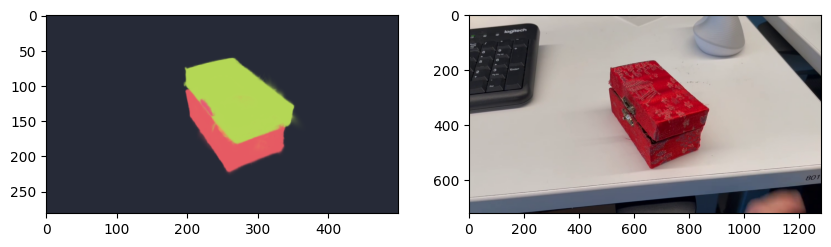

In [119]:

import moviepy.editor as mpy
import tqdm
video_path = Path("motion_vids/buddha_balls_closeopen.MOV")
assert video_path.exists()
motion_clip = cv2.VideoCapture(str(video_path.absolute()))
start=1.1
end=2.0
fps = 60
frame = get_vid_frame(motion_clip,start)
target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
_,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].imshow(outputs["rgb"].detach().cpu().numpy())
axs[1].imshow(target_frame_rgb.cpu().numpy())
plt.show()
optimizer.set_frame(target_frame_rgb)

# depth = get_depth(frame)
# plt.imshow(depth.cpu().numpy())
# plt.show()


In [120]:
from nerfstudio.utils.colormaps import apply_depth_colormap
try:
    animate_button.remove()
    frame_slider.remove()
    reset_button.remove()
except:
    pass
if len(rgb_renders)==0:
    for i in tqdm.tqdm(range(10)):
        target_vis_frame = resize(target_frame_rgb.permute(2,0,1),(outputs["rgb"].shape[0],outputs["rgb"].shape[1])).permute(1,2,0)
        #composite the outputs['rgb'] on top of target_vis frame
        target_vis_frame = target_vis_frame*0.5 + outputs["rgb"]*0.5
        vis_frame = torch.concatenate([outputs["rgb"],target_vis_frame],dim=1)
        rgb_renders.append(vis_frame.detach().cpu().numpy()*255)
        outputs = optimizer.step(40,use_depth=False)
for t in tqdm.tqdm(np.linspace(start,end,int((end-start)*fps))):
    frame = get_vid_frame(motion_clip,t)
    target_frame_rgb = ToTensor()(Image.fromarray(frame)).permute(1,2,0).cuda()
    optimizer.set_frame(target_frame_rgb)
    outputs = optimizer.step(70)
    optimizer.register_keyframe()
    v._trigger_rerender()
    target_vis_frame = resize(target_frame_rgb.permute(2,0,1),(outputs["rgb"].shape[0],outputs["rgb"].shape[1])).permute(1,2,0)
    # composite the outputs['rgb'] on top of target_vis frame
    target_vis_frame = target_vis_frame*0.5 + outputs["rgb"]*0.5
    vis_frame = torch.concatenate([outputs["rgb"],target_vis_frame],dim=1)
    rgb_renders.append(vis_frame.detach().cpu().numpy()*255)
#save as an mp4
out_clip = mpy.ImageSequenceClip(rgb_renders, fps=fps)
out_clip.write_videofile("optimizer_out.mp4", fps=fps,)

# Populate some viewer elements to visualize the animation
animate_button = v.viser_server.add_gui_button("Play Animation")
frame_slider = v.viser_server.add_gui_slider("Frame",0,len(optimizer.keyframes)-1,1,0)
reset_button = v.viser_server.add_gui_button("Reset Transforms")

@animate_button.on_click
def play_animation(_):
    for i in range(len(optimizer.keyframes)):
        optimizer.apply_keyframe(i)
        v._trigger_rerender()
        time.sleep(1/60)
@frame_slider.on_update
def apply_keyframe(_):
    optimizer.apply_keyframe(frame_slider.value)
    v._trigger_rerender()
@reset_button.on_click
def reset_transforms(_):
    optimizer.reset_transforms()
    v._trigger_rerender()

100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Moviepy - Building video optimizer_out.mp4.
Moviepy - Writing video optimizer_out.mp4



Moviepy - Done !
Moviepy - video ready optimizer_out.mp4


In [ ]:
%matplotlib widget
pipeline.model.eval()
outputs = pipeline.model.get_outputs_for_camera(train_cam_pose)
mask = outputs['accumulation']>.9
disparity = 1.0/outputs['depth']
disparity_mono = optimizer.frame_depth
scale_rend,shift_rend = get_scale_and_shift(disparity[mask])
scale_mono,shift_mono = get_scale_and_shift(disparity_mono[mask])
_,axs = plt.subplots(1,3,figsize=(18,4))
rend_norm = (disparity - shift_rend)/scale_rend
gt_norm = (disparity_mono - shift_mono)/scale_mono
gt_norm[~mask] = 0
axs[0].imshow(gt_norm.cpu().numpy())
axs[1].imshow(rend_norm.cpu().numpy())
# loss = (gt_norm - rend_norm).abs()
# losstrunc = loss[mask].quantile(.8)
# loss[loss > losstrunc] = 0
# loss[~mask] = 0
# axs[2].imshow(loss.cpu().numpy())
plt.show()